In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.constrained_layout.use'] = True

import dask
print(f'dask: {dask.__version__}')
import dask.array
dask.config.set({'array.chunk-size': '512MiB'})

import xarray as xr

from psutil import virtual_memory

mem = virtual_memory()
print(f'Physical memory: {mem.total/1024/1024/1024:.0f} Gb')  # total physical memory available

import logging
logging.basicConfig(filename='example.log', level=logging.DEBUG)

dask: 2022.02.0
Physical memory: 504 Gb


In [2]:
%load_ext autoreload

%autoreload 2

import toolbox_scs as tb
print(tb.__file__)
import toolbox_scs.routines.boz as boz

from extra_data.read_machinery import find_proposal

/gpfs/exfel/u/usr/SCS/202201/p002884/Software/checkouts/toolbox_p002884/src/toolbox_scs/__init__.py


# Loading analysis parameters

In [3]:
proposal = 2937
root = find_proposal(f'p{proposal:06d}')
path = root + '/usr/processed_runs/'

In [4]:
# list of tuple (runNB, darkrunNB)
runlist = [(688, 671),
           (690, 671)
          ]
savename = 'summary-688-690'

In [5]:
#xaxis = 'nrj'
xaxis = 'delay_mm'

In [6]:
fnames = [path + f'r{r:04d}/p{proposal}-r{r}-d{d}-BOZ-II1-small-data.h5'for r,d in runlist]

In [7]:
ds = xr.open_mfdataset(fnames, parallel=True, join='outer')
ds.load()
ds.close()
ds

<xarray.Dataset>
Dimensions:            (trainId: 25896, sa3_pId: 20, dim_0: 1, pulse_slot: 2700)
Coordinates:
  * sa3_pId            (sa3_pId) int64 602 642 682 722 ... 1242 1282 1322 1362
  * trainId            (trainId) uint64 1155313075 1155313076 ... 1155353394
Dimensions without coordinates: dim_0, pulse_slot
Data variables: (12/78)
    0                  (trainId, sa3_pId) float64 2.909e+05 ... 4.285e+05
    0X                 (trainId, sa3_pId) float64 6.245e+04 ... 9.256e+04
    0X_area            (dim_0, trainId, sa3_pId) float64 2.132e+03 ... 2.132e+03
    0X_sat             (trainId, sa3_pId) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    0_area             (dim_0, trainId, sa3_pId) float64 6.396e+03 ... 6.396e+03
    0_sat              (trainId, sa3_pId) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                 ...
    p                  (trainId, sa3_pId) float64 1.9e+05 ... 2.633e+05
    p_area             (dim_0, trainId, sa3_pId) float64 6.396e+03 ... 6.396e+03
    p_sat              (trainId, sa3_pId) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    sat                (trainId, sa3_pId) float64 6.683e+05 ... 9.515e+05
    sat_area           (dim_0, trainId, sa3_pId) float64 1.911e+04 ... 1.911e+04
    sat_sat            (trainId, sa3_pId) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    runFolder:       /gpfs/exfel/exp/SCS/202122/p002937/raw/r0688
    saturation (%):  6.896367959334262

In [8]:
if xaxis == 'delay_mm':
    bin_width = 0.05*0.15 #0.15mm is 1ps
else:
    bin_width = 0.1

In [9]:
dXAS = tb.xas(ds, bin_width, Iokey = 'p', Itkey = 'n', nrjkey = xaxis, plot=False)
XASp = tb.xas(ds, bin_width, Iokey = '0', Itkey = 'p', nrjkey = xaxis, plot=False)
XASn = tb.xas(ds, bin_width, Iokey = '0', Itkey = 'n', nrjkey = xaxis, plot=False)

In [10]:
ph = ds['nrj'].mean().values
t0 = 7.57 #mm
t = -(ds['delay_ps'].mean().values - t0/.15)

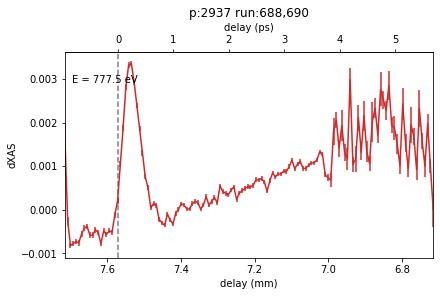

In [11]:
f = plt.figure()
ax = f.gca()
ax.errorbar(dXAS['nrj'], dXAS['muA'] - dXAS['muA'][0], dXAS['sterrA'], c='C3')
ax.set_ylabel('dXAS')
runs = ",".join([f'{r}' for r,d in runlist])
ax.set_title(f'p:{proposal} run:{runs}')
if xaxis == 'delay_mm':
    ax.set_xlabel('delay (mm)')
    ax.axvline(t0, c='k', alpha=0.5, ls='--')
    ax.text(0.02, 0.85, f'E = {ph:.1f} eV', transform=ax.transAxes)
    secax = ax.secondary_xaxis('top', functions=(lambda x: -(x - t0)/0.15,  lambda x: -x*0.15 + t0))
    secax.set_xlabel('delay (ps)')
    ax.set_xlim([np.nanmax(dXAS['nrj']), np.nanmin(dXAS['nrj'])])
if xaxis == 'nrj':
    ax.set_xlabel('Energy (eV)')
    ax.text(0.02, 0.85, f't = {t:.1f} ps', transform=ax.transAxes)
    ax2 = ax.twinx()
    ax2.errorbar(XASp['nrj'], XASp['muA'] - XASp['muA'][0], XASp['sterrA'], label='p')
    ax2.errorbar(XASn['nrj'], XASn['muA'] - XASn['muA'][0], XASn['sterrA'], label='n')
    ax2.set_ylabel('XAS')
    ax.legend(loc=2)

### save the figure

In [13]:
fname = path + savename + '.png'
f.savefig(fname, dpi=300)

# Saving binned data

In [14]:
dv = {}
for x, x_str in [(dXAS, 'dXAS'), (XASp, 'XASp'), (XASn, 'XASn')]:
    for k in x.keys():
        if k == 'nrj':
            continue
        dv[x_str + '_' + k] = {"dims": xaxis, "data": x[k]}

ds = {
    "coords": {xaxis: {"dims": xaxis, "data": dXAS['nrj'],
                     "attrs": {"units": "mm" if xaxis == 'delay_mm' else "eV"}}},
    "attrs": {"runs": runs},
    "dims": xaxis,
    "data_vars": dv}
ds = xr.Dataset.from_dict(ds)
ds

<xarray.Dataset>
Dimensions:      (delay_mm: 134)
Coordinates:
  * delay_mm     (delay_mm) float64 6.716 6.724 6.731 ... 7.699 7.706 7.714
Data variables: (12/15)
    dXAS_muA     (delay_mm) float64 0.01155 0.01254 0.01352 ... 0.01128 0.01315
    dXAS_sterrA  (delay_mm) float64 0.0003915 0.0001611 ... 9.847e-05 0.0003488
    dXAS_sigmaA  (delay_mm) float64 0.003796 0.003907 ... 0.003858 0.00347
    dXAS_muIo    (delay_mm) float64 2.107e+05 2.187e+05 ... 2.244e+05 2.267e+05
    dXAS_counts  (delay_mm) int64 94 588 307 247 467 ... 3495 3734 3749 1535 99
    XASp_muA     (delay_mm) float64 0.5399 0.5283 0.5279 ... 0.5221 0.5336
    ...           ...
    XASp_counts  (delay_mm) int64 94 588 307 247 467 ... 3495 3734 3749 1535 99
    XASn_muA     (delay_mm) float64 0.5514 0.5409 0.5414 ... 0.532 0.5334 0.5468
    XASn_sterrA  (delay_mm) float64 0.005814 0.002697 ... 0.001676 0.00694
    XASn_sigmaA  (delay_mm) float64 0.05637 0.0654 0.06379 ... 0.06566 0.06905
    XASn_muIo    (delay_mm) float64 3.615e+05 3.709e+05 ... 3.782e+05 3.865e+05
    XASn_counts  (delay_mm) int64 94 588 307 247 467 ... 3495 3734 3749 1535 99
Attributes:
    runs:     688,690

In [15]:
fname = path + savename + '.h5'
print(fname)
ds.to_netcdf(fname, format='NETCDF4', engine='h5netcdf')

/gpfs/exfel/exp/SCS/202122/p002937/usr/processed_runs/summary-688-690.h5
